# Imports and environment


In [87]:
import sys
import os
import warnings
import mne

warnings.filterwarnings("ignore")
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
mne.set_config("MNE_DATA", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_BNCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_EEGBCI_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MNE_DATASETS_SHIN_PATH", os.path.join(os.getcwd(), "data"))
mne.set_config("MOABB_RESULTS", os.path.join(os.getcwd(), "results"))
os.makedirs(os.environ["MNE_DATA"], exist_ok=True)
os.makedirs(os.environ["MOABB_RESULTS"], exist_ok=True)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from importlib import reload
from mne.decoding import CSP, PSDEstimator
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import scripts.multi_task.linear as linear
import scripts.multi_task.linear_data_selection as linear_ds
from scripts.features_extract.welch import extract_welch_features
from eeg_logger import logger

import moabb
from moabb.datasets import BNCI2014_004
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery

moabb.set_log_level("info")

# Instantiate dataset


In [105]:
dataset = BNCI2014_004()
dataset.subject_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
paradigm = LeftRightImagery(channels=None)
data = dataset.get_data(subjects=[1])
data[1]["0train"]["0"]

<RawArray | 7 x 604803 (2419.2 s), ~32.3 MiB, data loaded>

# Prepare train and test data

The data is organised as follows:

- **X_all** - all data from epochs regarding left/right hand movement
- **y_all** - all labels from epochs regarding left/right hand movement
- **X_train** - array of shape (n_subjects, ) where each element is another numpy array of shape (4, ) representing 4 sessions of each patient.
- **y_train** - array of shape (n_subjects, ) where each element is another numpy array of shape (4, ) representing sessions' labels for each patient
- **X_test** - array of shape (n_subjects, ) where each element represents data from the last session of each subject
- **y_test** - array of shape (n_subjects, ) where each element represents labels from the last session of each subject


In [89]:
X_all, y_all, metadata = paradigm.get_data(dataset, subjects=dataset.subject_list, return_epochs=False)
subjects = metadata["subject"].unique()
sessions = metadata["session"].unique()

X_train = np.empty(len(subjects), dtype=object)
X_test = np.empty(len(subjects), dtype=object)
y_train = np.empty(len(subjects), dtype=object)
y_test = np.empty(len(subjects), dtype=object)
label_map = {"left_hand": 1, "right_hand": -1}

for idx, subject in enumerate(subjects):

    sess_1_mask = (metadata["subject"] == subject) & (metadata["session"] == "0train")
    sess_2_mask = (metadata["subject"] == subject) & (metadata["session"] == "1train")
    sess_3_mask = (metadata["subject"] == subject) & (metadata["session"] == "2train")
    sess_4_mask = (metadata["subject"] == subject) & (metadata["session"] == "3test")
    sess_5_mask = (metadata["subject"] == subject) & (metadata["session"] == "4test")

    X_sess_1 = X_all[sess_1_mask]
    y_sess_1 = y_all[sess_1_mask]
    X_sess_2 = X_all[sess_2_mask]
    y_sess_2 = y_all[sess_2_mask]
    X_sess_3 = X_all[sess_3_mask]
    y_sess_3 = y_all[sess_3_mask]
    X_sess_4 = X_all[sess_4_mask]
    y_sess_4 = y_all[sess_4_mask]
    X_sess_5 = X_all[sess_5_mask]
    y_sess_5 = y_all[sess_5_mask]

    X_sess_1_feat = extract_welch_features(X_sess_1)
    y_sess_1 = np.array([label_map[label] for label in y_sess_1])
    X_sess_2_feat = extract_welch_features(X_sess_2)
    y_sess_2 = np.array([label_map[label] for label in y_sess_2])
    X_sess_3_feat = extract_welch_features(X_sess_3)
    y_sess_3 = np.array([label_map[label] for label in y_sess_3])
    X_sess_4_feat = extract_welch_features(X_sess_4)
    y_sess_4 = np.array([label_map[label] for label in y_sess_4])
    X_sess_5_feat = extract_welch_features(X_sess_5)
    y_sess_5 = np.array([label_map[label] for label in y_sess_5])

    X_subject_train = np.empty(4, dtype=object)
    X_subject_train[0] = X_sess_1_feat.T
    X_subject_train[1] = X_sess_2_feat.T
    X_subject_train[2] = X_sess_3_feat.T
    X_subject_train[3] = X_sess_4_feat.T
    y_subject_train = np.empty(4, dtype=object)
    y_subject_train[0] = y_sess_1.reshape(-1, 1)
    y_subject_train[1] = y_sess_2.reshape(-1, 1)
    y_subject_train[2] = y_sess_3.reshape(-1, 1)
    y_subject_train[3] = y_sess_4.reshape(-1, 1)

    X_train[idx] = X_subject_train
    y_train[idx] = y_subject_train
    X_test[idx] = X_sess_5_feat.T
    y_test[idx] = y_sess_5.reshape(-1, 1)

2025-07-14 10:22:42,859 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-14 10:22:43,038 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-14 10:22:43,260 - INFO - Welch features extracted, vector's shape: (160, 24)
2025-07-14 10:22:43,493 - INFO - Welch features extracted, vector's shape: (160, 24)
2025-07-14 10:22:43,726 - INFO - Welch features extracted, vector's shape: (160, 24)
2025-07-14 10:22:43,902 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-14 10:22:44,067 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-14 10:22:44,288 - INFO - Welch features extracted, vector's shape: (160, 24)
2025-07-14 10:22:44,451 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-14 10:22:44,673 - INFO - Welch features extracted, vector's shape: (160, 24)
2025-07-14 10:22:44,847 - INFO - Welch features extracted, vector's shape: (120, 24)
2025-07-14 10:22:45,021 - INFO - Welch features extracted, vector

# Testing classifier across sessions (Algorithm 1)

First, classifier learns basic prior info based on four sessions of current patient.  
This creates a shared model with prior info.  
Then shared model is tested on the fifth session of current patient.


In [106]:
accuracies = []
algorithm_1_results = {"subjects": subjects}
for idx, subject in enumerate(subjects):
    clf = linear.MultiTaskLinearClassifier(regularization=0.1, zero_mean=False, cov_flag="l2-trace")
    clf.fit_sessions(X_train[idx], y_train[idx])
    acc, y_pred = clf.score(X_test[idx], y_test[idx])
    accuracies.append(acc)
    algorithm_1_results[f"subj_{idx+1}_test_labels"] = y_test[idx]
    algorithm_1_results[f"subj_{idx+1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")
logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_1_results["accuracies"] = accuracies

2025-07-14 10:32:15,076 - INFO - Iteration 1, error = 14.752069393978266
2025-07-14 10:32:15,079 - INFO - Iteration 2, error = 2.6462315126521654
2025-07-14 10:32:15,081 - INFO - Iteration 3, error = 0.8152969343318545
2025-07-14 10:32:15,084 - INFO - Iteration 4, error = 0.6004798869957915
2025-07-14 10:32:15,087 - INFO - Iteration 5, error = 0.5254712773705669
2025-07-14 10:32:15,090 - INFO - Iteration 6, error = 0.5208963799999561
2025-07-14 10:32:15,092 - INFO - Iteration 7, error = 0.5421911801216829
2025-07-14 10:32:15,095 - INFO - Iteration 8, error = 0.5177876697615966
2025-07-14 10:32:15,098 - INFO - Iteration 9, error = 0.34783177783129254
2025-07-14 10:32:15,100 - INFO - Iteration 10, error = 0.10513275207078071
2025-07-14 10:32:15,102 - INFO - Iteration 11, error = 0.02153853366035568
2025-07-14 10:32:15,104 - INFO - Iteration 12, error = 0.014024530229416028
2025-07-14 10:32:15,106 - INFO - Iteration 13, error = 0.010325823956731114
2025-07-14 10:32:15,108 - INFO - Iterati

# Plot results (Algorithm 1)


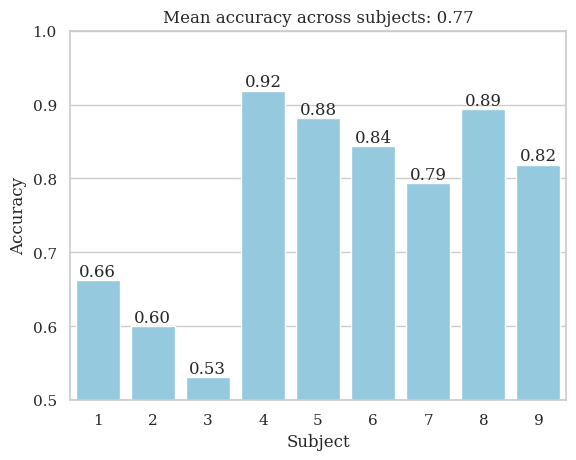

In [107]:
axes = sns.barplot(data=algorithm_1_results, y="accuracies", x="subjects", zorder=1, color="skyblue")
axes.set_ylim(0.5, 1)
axes.bar_label(axes.containers[0], fmt="%.2f")
axes.set_title(f"Mean accuracy across subjects: {np.mean(algorithm_1_results["accuracies"]):.2f}")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Subject")
plt.show()

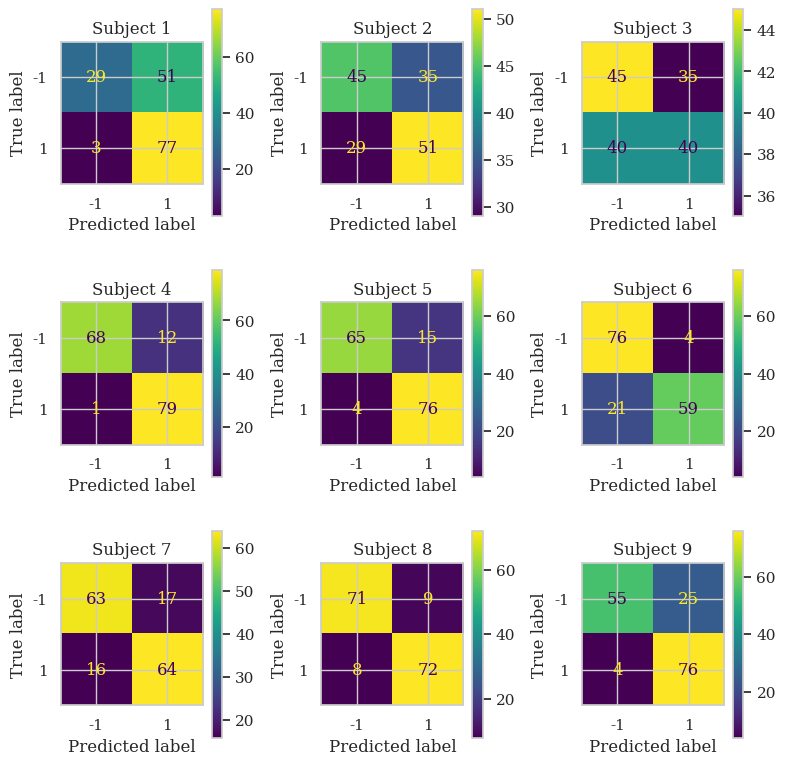

In [108]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()

for i, subj_idx in enumerate(subjects):
    test = algorithm_1_results[f"subj_{subj_idx}_test_labels"]
    pred = algorithm_1_results[f"subj_{subj_idx}_pred_labels"]
    cm = confusion_matrix(test, pred, labels=[-1, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
    disp.plot(ax=axes[i], values_format="d")
    axes[i].set_title(f"Subject {subj_idx}")
plt.tight_layout()

# Testing classifier across sessions (Algorithm 2)

First, shared model is acquired the same way as for previous testing pipeline.  
Next, the fifth session is split into train and test data.  
The train data is used to calculate weight vector for this task and select prior vectors that match the new vector the most.  
Finally, the classifier is tested on the remaining data from fifth session.


In [109]:
def split_test_session(X: np.ndarray, y: np.ndarray):
    from sklearn.model_selection import train_test_split

    X_adapt, X_eval, y_adapt, y_eval = train_test_split(X.T, y, train_size=0.5, shuffle=True, random_state=42)
    return X_adapt.T, X_eval.T, y_adapt, y_eval


accuracies = []
algorithm_2_results = {"subjects": subjects}
for idx, subject in enumerate(subjects):

    clf = linear_ds.MultiTaskLinearWithSelectionClassifier(regularization=0.1, zero_mean=False, cov_flag="l2-trace")
    clf.fit_sessions(X_train[idx], y_train[idx])

    X_adapt, X_eval, y_adapt, y_eval = split_test_session(X_test[idx], y_test[idx])
    clf.fit(X_adapt, y_adapt)
    acc, y_pred = clf.score(X_eval, y_eval)

    accuracies.append(acc)
    algorithm_2_results[f"subj_{idx+1}_test_labels"] = y_eval
    algorithm_2_results[f"subj_{idx+1}_pred_labels"] = y_pred
    logger.info(f"Accuracy for subject {idx}: {acc:.2f}")
logger.info(f"Mean accuracy across subjects: {np.mean(accuracies):.2f}")
algorithm_2_results["accuracies"] = accuracies

2025-07-14 10:32:35,362 - INFO - Iteration 1, error = 14.752069393978266
2025-07-14 10:32:35,365 - INFO - Iteration 2, error = 2.6462315126521654
2025-07-14 10:32:35,369 - INFO - Iteration 3, error = 0.8152969343318545
2025-07-14 10:32:35,371 - INFO - Iteration 4, error = 0.6004798869957915
2025-07-14 10:32:35,373 - INFO - Iteration 5, error = 0.5254712773705669
2025-07-14 10:32:35,376 - INFO - Iteration 6, error = 0.5208963799999561
2025-07-14 10:32:35,379 - INFO - Iteration 7, error = 0.5421911801216829
2025-07-14 10:32:35,381 - INFO - Iteration 8, error = 0.5177876697615966
2025-07-14 10:32:35,385 - INFO - Iteration 9, error = 0.34783177783129254
2025-07-14 10:32:35,387 - INFO - Iteration 10, error = 0.10513275207078071
2025-07-14 10:32:35,389 - INFO - Iteration 11, error = 0.02153853366035568
2025-07-14 10:32:35,392 - INFO - Iteration 12, error = 0.014024530229416028
2025-07-14 10:32:35,394 - INFO - Iteration 13, error = 0.010325823956731114
2025-07-14 10:32:35,396 - INFO - Iterati

# Plot results (Algorithm 2)


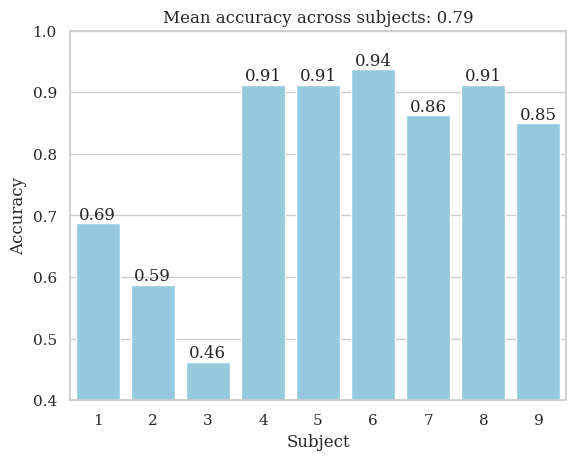

In [110]:
axes = sns.barplot(data=algorithm_2_results, y="accuracies", x="subjects", zorder=1, color="skyblue")
axes.set_ylim(0.4, 1)
axes.bar_label(axes.containers[0], fmt="%.2f")
axes.set_title(f"Mean accuracy across subjects: {np.mean(algorithm_2_results["accuracies"]):.2f}")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Subject")
plt.show()

# Testing classifier across subjects (Algorithm 1)

Here, classifier is used on data from sessions between subjects. The pipeline is build like this:

- use all sessions from current subject (Si) and I sessions from next subject (Sm), where I = 1...4 as training data to build shared model
- test the model on I + 1 session data of subject Sm


### Prepare data first - concatenate data from previous train and test arrays for easier selection.  
- **X_cross_subj** - shape (n_subjects, ) that contains 5 numpy arrays for each session
- **y_cross_subj** - shape (n_subjects, ) that contains 5 numpy arrays for labels for each session

In [111]:
X_cross_subj = np.empty(len(subjects), dtype=object)
y_cross_subj = np.empty(len(subjects), dtype=object)

for idx, subj in enumerate(subjects):

    X_si_train = X_train[idx]
    y_si_train = y_train[idx]
    X_si_test = X_test[idx]
    y_si_test = y_test[idx]
    X_si_test_wrapped = np.empty(1, dtype=object)
    X_si_test_wrapped[0] = X_si_test
    y_si_test_wrapped = np.empty(1, dtype=object)
    y_si_test_wrapped[0] = y_si_test
    X_si_all = np.concatenate((X_si_train, X_si_test_wrapped), axis=0)
    y_si_all = np.concatenate((y_si_train, y_si_test_wrapped), axis=0)

    X_cross_subj[idx] = X_si_all
    y_cross_subj[idx] = y_si_all

### Use cross-subject data for classification (Algorithm 1)

In [112]:
cross_subject_results = []
accuracies = []
for subj_idx, _ in enumerate(subjects):
    next_subj_idx = subj_idx + 1
    if next_subj_idx == len(subjects):
        break

    for sess_idx in range(1, len(sessions) + 1):
        if sess_idx == len(sessions):
            break

        X_cs_train = np.concatenate((X_cross_subj[subj_idx], X_cross_subj[next_subj_idx][:sess_idx]))
        y_cs_train = np.concatenate((y_cross_subj[subj_idx], y_cross_subj[next_subj_idx][:sess_idx]))
        X_cs_test = X_cross_subj[next_subj_idx][sess_idx]
        y_cs_test = y_cross_subj[next_subj_idx][sess_idx]
        
        clf = linear.MultiTaskLinearClassifier(regularization=0.1, cov_flag="l2-trace", zero_mean=False)
        clf.fit_sessions(X_cs_train, y_cs_train)

        acc, y_pred = clf.score(X_cs_test, y_cs_test)

        cross_subject_results.append(
            {
                "train_desc": f"S{subj_idx + 1}",
                "eval_desc": f"S{next_subj_idx + 1}:{sess_idx + 1}",
                "accuracy": acc,
            }
        )
        accuracies.append(acc)

        logger.info(
            f"Training on S{subj_idx} + S{next_subj_idx}:{sess_idx}, test on S{next_subj_idx}:{sess_idx + 1} acc = {acc:.2f}"
        )
        
logger.info(f"Mean accuracy: {np.mean(accuracies):.2f}")

2025-07-14 10:33:15,236 - INFO - Iteration 1, error = 19.06315323786429
2025-07-14 10:33:15,240 - INFO - Iteration 2, error = 5.471513764589233
2025-07-14 10:33:15,243 - INFO - Iteration 3, error = 1.6408885938846314
2025-07-14 10:33:15,246 - INFO - Iteration 4, error = 1.239959824549242
2025-07-14 10:33:15,250 - INFO - Iteration 5, error = 1.043609399269582
2025-07-14 10:33:15,252 - INFO - Iteration 6, error = 0.6974770378341211
2025-07-14 10:33:15,255 - INFO - Iteration 7, error = 0.21831296443986598
2025-07-14 10:33:15,258 - INFO - Iteration 8, error = 0.02576775268885502
2025-07-14 10:33:15,261 - INFO - Iteration 9, error = 0.005779546625283717
2025-07-14 10:33:15,264 - INFO - Iteration 10, error = 0.0015898922279648097
2025-07-14 10:33:15,266 - INFO - Iteration 11, error = 0.0004546022258625499
2025-07-14 10:33:15,269 - INFO - Iteration 12, error = 0.0001378010879597695
2025-07-14 10:33:15,272 - INFO - Iteration 13, error = 4.5414068146146606e-05
2025-07-14 10:33:15,275 - INFO - I

# Plot cross-subject accuracy (Algorithm 1)


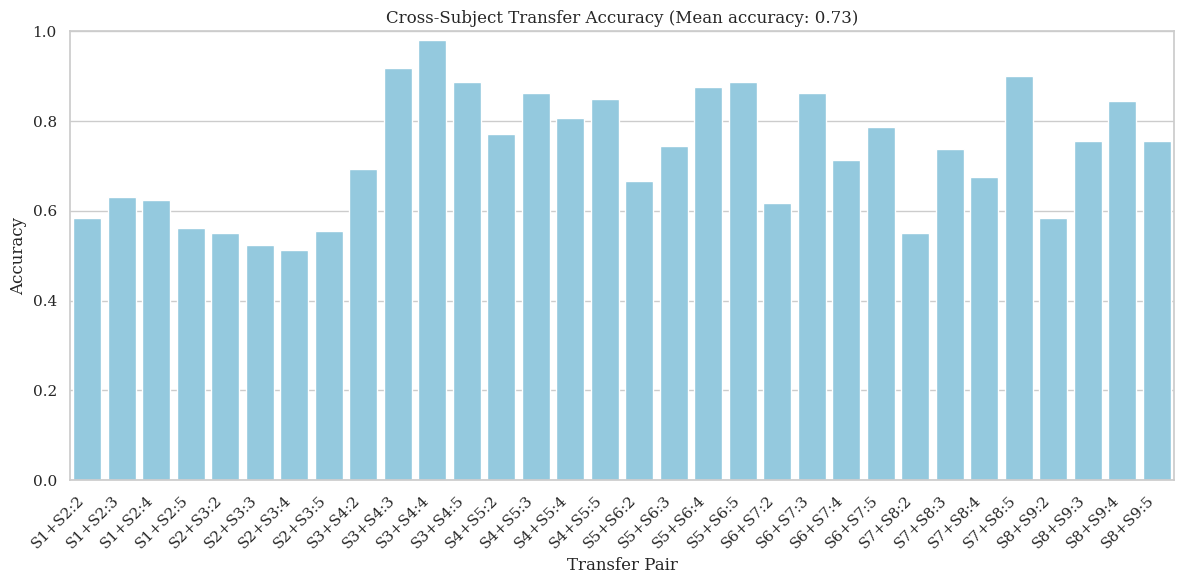

In [113]:
df = pd.DataFrame(cross_subject_results)
df["transfer_pair"] = df["train_desc"] + "+" + df["eval_desc"]

plt.figure(figsize=(12, 6))
axes = sns.barplot(data=df, x="transfer_pair", y="accuracy", color="skyblue")
axes.set_ylim(0, 1)
axes.set_title(f"Cross-Subject Transfer Accuracy (Mean accuracy: {np.mean(accuracies):.2f})")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Transfer Pair")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Testing classifier across subjects (Algorithm 2)

The pipeline is the same as in ALgorithm 1, except the test session is split before fine-tuning the shared model.

In [114]:
cross_subject_results = []
accuracies = []
for subj_idx, _ in enumerate(subjects):
    next_subj_idx = subj_idx + 1
    if next_subj_idx == len(subjects):
        break

    for sess_idx in range(1, len(sessions) + 1):
        if sess_idx == len(sessions):
            break

        X_cs_train = np.concatenate((X_cross_subj[subj_idx], X_cross_subj[next_subj_idx][:sess_idx]))
        y_cs_train = np.concatenate((y_cross_subj[subj_idx], y_cross_subj[next_subj_idx][:sess_idx]))
        X_cs_test = X_cross_subj[next_subj_idx][sess_idx]
        y_cs_test = y_cross_subj[next_subj_idx][sess_idx]
        
        clf = linear_ds.MultiTaskLinearWithSelectionClassifier(regularization=0.1, cov_flag="l2-trace", zero_mean=False)
        clf.fit_sessions(X_cs_train, y_cs_train)

        X_adapt, X_eval, y_adapt, y_eval = split_test_session(X_cs_test, y_cs_test)
        clf.fit(X_adapt, y_adapt)
        acc, y_pred = clf.score(X_eval, y_eval)

        cross_subject_results.append(
            {
                "train_desc": f"S{subj_idx + 1}",
                "eval_desc": f"S{next_subj_idx + 1}:{sess_idx + 1}",
                "accuracy": acc,
            }
        )
        accuracies.append(acc)

        logger.info(
            f"Training on S{subj_idx} + S{next_subj_idx}:{sess_idx}, test on S{next_subj_idx}:{sess_idx + 1} acc = {acc:.2f}"
        )
        
logger.info(f"Mean accuracy: {np.mean(accuracies):.2f}")

2025-07-14 10:33:43,779 - INFO - Iteration 1, error = 19.06315323786429
2025-07-14 10:33:43,783 - INFO - Iteration 2, error = 5.471513764589233
2025-07-14 10:33:43,787 - INFO - Iteration 3, error = 1.6408885938846314
2025-07-14 10:33:43,789 - INFO - Iteration 4, error = 1.239959824549242
2025-07-14 10:33:43,793 - INFO - Iteration 5, error = 1.043609399269582
2025-07-14 10:33:43,796 - INFO - Iteration 6, error = 0.6974770378341211
2025-07-14 10:33:43,798 - INFO - Iteration 7, error = 0.21831296443986598
2025-07-14 10:33:43,801 - INFO - Iteration 8, error = 0.02576775268885502
2025-07-14 10:33:43,804 - INFO - Iteration 9, error = 0.005779546625283717
2025-07-14 10:33:43,807 - INFO - Iteration 10, error = 0.0015898922279648097
2025-07-14 10:33:43,809 - INFO - Iteration 11, error = 0.0004546022258625499
2025-07-14 10:33:43,812 - INFO - Iteration 12, error = 0.0001378010879597695
2025-07-14 10:33:43,814 - INFO - Iteration 13, error = 4.5414068146146606e-05
2025-07-14 10:33:43,817 - INFO - I

# Plot cross-subject accuracy (Algorithm 2)

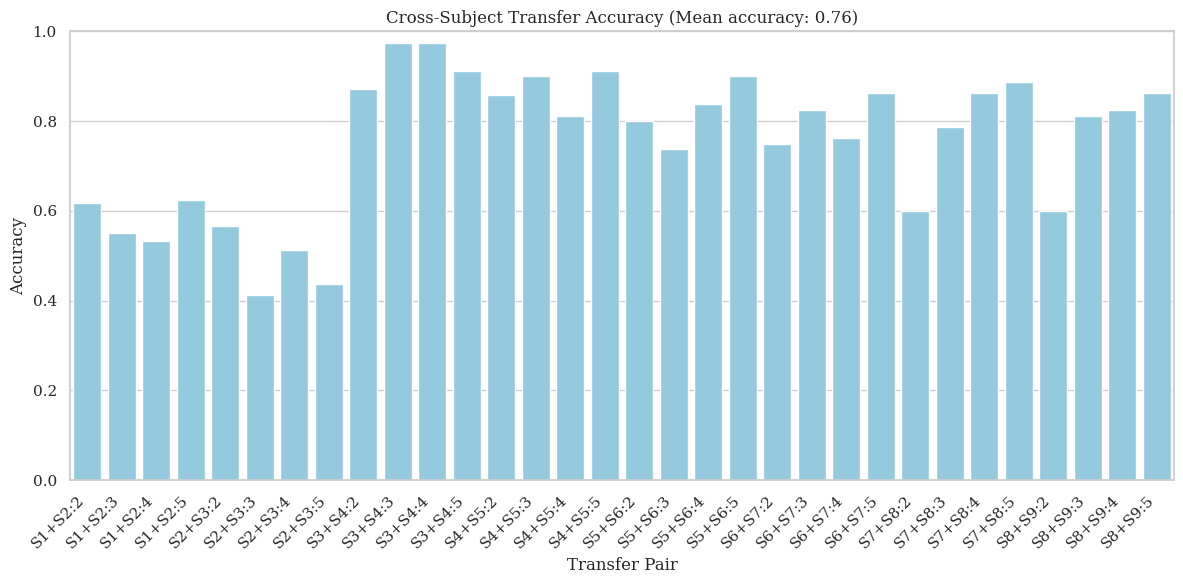

In [115]:
df = pd.DataFrame(cross_subject_results)
df["transfer_pair"] = df["train_desc"] + "+" + df["eval_desc"]

plt.figure(figsize=(12, 6))
axes = sns.barplot(data=df, x="transfer_pair", y="accuracy", color="skyblue")
axes.set_ylim(0, 1)
axes.set_title(f"Cross-Subject Transfer Accuracy (Mean accuracy: {np.mean(accuracies):.2f})")
axes.set_ylabel("Accuracy")
axes.set_xlabel("Transfer Pair")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()